In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import optim
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.helpers.tokenizer import CharNgramTokenizer
from torchlake.common.helpers.transform import CustomVocabTransform
from torchlake.common.helpers.vocab import CharNgramVocab
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import is_longer_text
from torchlake.language_model.constants.enum import LossType
from torchlake.text_classification.datasets.ag_news.constants import \
    CLASS_NAMES as AG_NEWS_CLASS_NAMES
from torchlake.text_classification.models import FastText
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import AG_NEWS

To utilize this notebook, you have to install `portalocker`, `spacy` first

# setting


In [3]:
DATASET_NAME = "AGNews"

In [4]:
artifact_path = Path('../../artifacts/fasttext')
artifact_dataset_path = artifact_path / DATASET_NAME
data_path = Path('../../data') / DATASET_NAME

In [5]:
NUM_CLASS = len(AG_NEWS_CLASS_NAMES)

In [6]:
CONTEXT = NlpContext(
    max_seq_len=256, # word length, not ngram length
)

In [7]:
BATCH_SIZE = 32
MINIMUM_LENGTH = 5

In [8]:
DEVICE = torch.device(CONTEXT.device)

In [9]:
BUCKET_SIZE = 1 * 10**5 # should be smaller than ngram size

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
ngram_vocab = CharNgramVocab(BUCKET_SIZE, context=CONTEXT)
ngram_tokenizer = CharNgramTokenizer(tokenizer, ngram_vocab, ngrams=[2]) # [3,4,5,6] is used in paper

In [12]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    ngram_transform=None,
    word_transform=None,
    word_spans_transform=None,
):
    datapipe = (
        datapipe
        .map(lambda pair: (pair[1], pair[0])) # label, text -> text, label
        .map(lambda pair: (pair[0].strip(), pair[1]))
        .map(lambda pair: (pair[0].lower(), pair[1]))
        .filter(lambda pair: is_longer_text(pair[0], minimum_length))
        .map(
            lambda pair: (ngram_tokenizer(pair[0]), pair[1])
        )  # label, (grams, words, word_spans)
    )

    if ngram_transform:
        datapipe = datapipe.map(
            lambda pair: (
                (
                    ngram_transform(pair[0][0]),
                    word_transform(pair[0][1]),
                    word_spans_transform(pair[0][2]),
                ),
                pair[1] - 1,
            )  # (grams, words, word_spans), label
        )

    return datapipe

In [13]:
train_datapipe, test_datapipe = AG_NEWS(data_path.as_posix())

In [14]:
# create vocabulary
cloned_train_datapipe = datapipe_factory(train_datapipe, MINIMUM_LENGTH)
for _ in cloned_train_datapipe:
    pass

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [15]:
def datapipe_factory_for_vocab(datapipe, minimum_length: int = 1):
    datapipe = (
        datapipe.map(lambda pair: pair[1])
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, minimum_length))
        .map(lambda text: ngram_tokenizer.tokenizer(text))
    )

    return datapipe

In [16]:
# optional for KNN search
ngram_vocab.build_word_vocab(
    datapipe_factory_for_vocab(train_datapipe, minimum_length=MINIMUM_LENGTH)
)

In [17]:
VOCAB_SIZE = len(ngram_vocab.word_vocab)
VOCAB_SIZE

30335

In [18]:
print("cache size:", len(ngram_vocab))

cache size: 99515


In [19]:
ngram_vocab.save_word_vocab(artifact_dataset_path / "words.json")
ngram_vocab.save_subword_vocab(artifact_dataset_path / "grams.json")

In [20]:
ngram_vocab.load_word_vocab(artifact_dataset_path / "words.json")
ngram_vocab.load_subword_vocab(artifact_dataset_path / "grams.json")

In [21]:
get_file_size(artifact_dataset_path / "words.json")

'0.52MiB'

In [22]:
get_file_size(artifact_dataset_path / "grams.json")

'1.83MiB'

In [23]:
ngram_transform = T.Sequential(
    CustomVocabTransform(ngram_vocab),
    T.ToTensor(),
)

In [24]:
word_transform = T.Sequential(
    T.Truncate(CONTEXT.max_seq_len),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [25]:
word_spans_transform = T.Sequential(
    T.Truncate(CONTEXT.max_seq_len),
    T.ToTensor(),
)

In [26]:
train_datapipe = datapipe_factory(
    train_datapipe,
    MINIMUM_LENGTH,
    ngram_transform,
    word_transform,
    word_spans_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    MINIMUM_LENGTH,
    ngram_transform,
    word_transform,
    word_spans_transform,
)

In [27]:
count = 0
for (grams, words, word_lengths), label in train_datapipe:
    print(grams.shape)
    print(words.shape)
    print(word_lengths.shape)
    print(label)
    if count > 10:
        break
    count+=1

torch.Size([104])
torch.Size([256])
torch.Size([29])
2
torch.Size([196])
torch.Size([256])
torch.Size([42])
2
torch.Size([162])
torch.Size([256])
torch.Size([40])
2
torch.Size([187])
torch.Size([256])
torch.Size([40])
2
torch.Size([163])
torch.Size([256])
torch.Size([43])
2
torch.Size([163])
torch.Size([256])
torch.Size([48])
2
torch.Size([140])
torch.Size([256])
torch.Size([47])
2
torch.Size([176])
torch.Size([256])
torch.Size([49])
2
torch.Size([275])
torch.Size([256])
torch.Size([88])
2
torch.Size([101])
torch.Size([256])
torch.Size([31])
2
torch.Size([155])
torch.Size([256])
torch.Size([44])
2
torch.Size([181])
torch.Size([256])
torch.Size([56])
2


In [28]:
NUM_WORKERS = get_num_workers()

In [29]:
def collate_fn(
    batch: list[torch.Tensor],
    device: torch.device,
) -> tuple[list[torch.Tensor], list[torch.Tensor], list[torch.Tensor], torch.Tensor]:
    ngrams, words, word_spans = [], [], []
    labels = []
    
    for (ngram, word, word_span), label in batch:
        # truncate ngram with word length
        # move to gpu here
        # TODO: more trackable some other days
        ngrams.append(ngram[:sum(word_span)].to(device))
        words.append(word)
        word_spans.append(word_span.to(device))
        labels.append(label)

    return (ngrams, torch.stack(words).to(device), word_spans), torch.LongTensor(labels).to(device)

In [30]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    # pin_memory=True,
    num_workers=NUM_WORKERS,
    collate_fn=lambda x: collate_fn(x, DEVICE),
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    # pin_memory=True,
    num_workers=NUM_WORKERS,
    collate_fn=lambda x: collate_fn(x, DEVICE),
)

In [31]:
count = 0
for (grams, words, word_spans), label in train_dataloader:
    print(len(grams), *[gram.shape for gram in grams[:4]])
    print(words.shape)
    print(len(word_spans), *[word_span.shape for word_span in word_spans[:4]])
    print(label.shape)
    if count > 10:
        break
    count+=1

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


32 torch.Size([104]) torch.Size([196]) torch.Size([162]) torch.Size([187])
torch.Size([32, 256])
32 torch.Size([29]) torch.Size([42]) torch.Size([40]) torch.Size([40])
torch.Size([32])
32 torch.Size([100]) torch.Size([110]) torch.Size([103]) torch.Size([119])
torch.Size([32, 256])
32 torch.Size([36]) torch.Size([34]) torch.Size([26]) torch.Size([32])
torch.Size([32])
32 torch.Size([216]) torch.Size([247]) torch.Size([253]) torch.Size([225])
torch.Size([32, 256])
32 torch.Size([66]) torch.Size([74]) torch.Size([68]) torch.Size([62])
torch.Size([32])
32 torch.Size([95]) torch.Size([95]) torch.Size([176]) torch.Size([228])
torch.Size([32, 256])
32 torch.Size([31]) torch.Size([35]) torch.Size([42]) torch.Size([65])
torch.Size([32])
32 torch.Size([202]) torch.Size([164]) torch.Size([130]) torch.Size([217])
torch.Size([32, 256])
32 torch.Size([51]) torch.Size([43]) torch.Size([47]) torch.Size([56])
torch.Size([32])
32 torch.Size([212]) torch.Size([197]) torch.Size([210]) torch.Size([432])
to

# training


In [32]:
EMBED_DIM = 300

In [33]:
EPOCHES = 10
ACC_ITERS = max(32 / BATCH_SIZE, 1)
LR = 1e-3

In [79]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, ACC_ITERS, feature_last=True)

In [34]:
model = FastText(
    BUCKET_SIZE,
    EMBED_DIM,
    NUM_CLASS,
    loss_type=LossType.CROSS_ENTROPY,
    context=CONTEXT,
).to(DEVICE)

In [81]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [82]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
FastText                                 --
├─SubwordEmbedding: 1-1                  --
│    └─Embedding: 2-1                    30,000,000
│    └─Embedding: 2-2                    1,200
├─Linear: 1-2                            1,204
Total params: 30,002,404
Trainable params: 30,002,404
Non-trainable params: 0

In [37]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion)


3750it [02:27, 25.41it/s]


epoch 1 : 0.3724533801118533


3750it [02:15, 27.60it/s]


epoch 2 : 0.16477494599272807


3750it [02:18, 27.05it/s]


epoch 3 : 0.13408915094733237


3750it [02:24, 25.97it/s]


epoch 4 : 0.11686723314672709


3750it [02:14, 27.96it/s]


epoch 5 : 0.10469017231836915


3750it [02:20, 26.71it/s]


epoch 6 : 0.09511124613210559


3750it [02:18, 27.10it/s]


epoch 7 : 0.08711054726516207


3750it [02:19, 26.94it/s]


epoch 8 : 0.08022307246526082


3750it [02:28, 25.28it/s]


epoch 9 : 0.07418334598727525


3750it [02:26, 25.62it/s]

epoch 10 : 0.06880933721022059


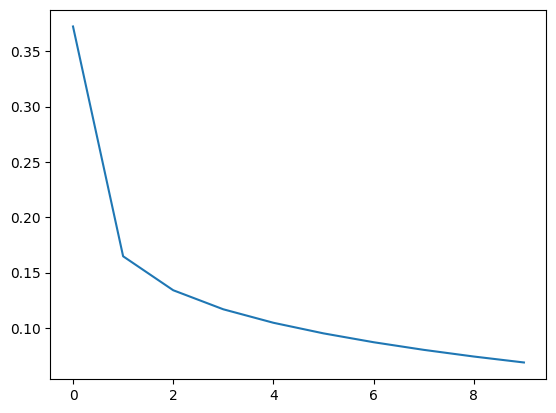

In [38]:
plt.plot(training_loss)

# Inference

In [39]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [40]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

237it [00:10, 21.62it/s]

[[1738   55   68   39]
 [  13 1869   10    2]
 [  78   12 1684  125]
 [  66   20  153 1636]]


In [41]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.9147368421052632
sports    : 0.9868004223864836
business  : 0.8867825171142707
science   : 0.8725333333333334


In [42]:
per_class_acc.mean()

0.9152132787348377

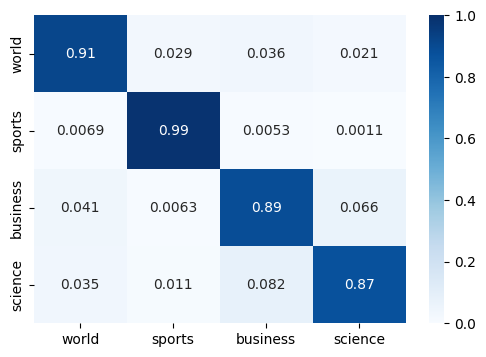

In [43]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

# File


In [35]:
model_path = artifact_path / "fasttext.pth"

In [45]:
torch.save(model.state_dict(), model_path)

In [35]:
get_file_size(model_path)

'114.45MiB'

In [137]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Product Quantization

In [138]:
from torchlake.common.helpers.quantizer import ProductQuantization, get_compression_ratio

In [139]:
quantizer = ProductQuantization(k=50)

In [140]:
vectors = model.embeddings.weight.data.clone()

In [141]:
vectors

tensor([[-0.2977,  1.6751, -0.2600,  ...,  0.0665, -1.0991,  0.1561],
        [ 0.8621, -0.5486,  0.2356,  ...,  0.4201,  0.3472,  0.6238],
        [-0.6113, -0.7099, -1.3545,  ...,  0.1208,  0.5920,  0.2054],
        ...,
        [ 0.7196, -1.1708,  0.0050,  ...,  0.2591, -0.4873, -1.7383],
        [-0.1107, -1.4340, -0.2777,  ..., -1.4994,  0.3745,  0.0311],
        [ 0.8859,  2.6990,  0.8034,  ...,  0.6098, -1.0167, -0.8026]],
       device='cuda:0')

In [142]:
quantized_indices = quantizer.quantize(vectors.detach().cpu())

init evaluation score: tensor(0.9366)
new evaluation score: tensor(0.7332)
init evaluation score: tensor(0.9080)
new evaluation score: tensor(0.7257)
init evaluation score: tensor(0.8428)
new evaluation score: tensor(0.7287)
init evaluation score: tensor(1.0408)
new evaluation score: tensor(0.7374)
init evaluation score: tensor(0.8456)
new evaluation score: tensor(0.7401)
init evaluation score: tensor(1.0341)
new evaluation score: tensor(0.7147)
init evaluation score: tensor(0.9890)
new evaluation score: tensor(0.7298)
init evaluation score: tensor(0.9565)
new evaluation score: tensor(0.7376)
init evaluation score: tensor(1.0118)
new evaluation score: tensor(0.7290)
init evaluation score: tensor(0.9875)
new evaluation score: tensor(0.7212)
init evaluation score: tensor(0.8607)
new evaluation score: tensor(0.7144)
init evaluation score: tensor(0.9112)
new evaluation score: tensor(0.7465)
init evaluation score: tensor(0.8074)
new evaluation score: tensor(0.7260)
init evaluation score: te

In [143]:
get_compression_ratio(vectors, quantizer.codebook, quantized_indices)

0.04174666666666667

In [144]:
reconstructed_vectors = quantizer.reconstruct(quantized_indices.long())

In [145]:
import torch.nn.functional as F

print("quantization error", F.mse_loss(vectors.detach().cpu(), reconstructed_vectors))

quantization error tensor(0.7288)


In [146]:
model.embeddings.weight.data.copy_(reconstructed_vectors)

tensor([[ 5.6082e-01,  4.6055e-01, -7.0085e-01,  ..., -1.7091e-04,
         -5.6791e-01,  5.6528e-01],
        [-2.1667e-01, -9.5067e-01,  6.2092e-01,  ...,  1.0502e-01,
          3.1280e-01,  1.1136e+00],
        [-5.3196e-01,  3.9757e-01, -4.4569e-01,  ..., -1.7091e-04,
         -5.6791e-01,  5.6528e-01],
        ...,
        [ 4.5436e-01, -6.4711e-01,  4.6075e-01,  ...,  7.8643e-01,
          7.8176e-01,  2.4869e-02],
        [-2.6512e-01,  2.9283e-01,  2.3335e-01,  ..., -1.5096e+00,
         -1.3425e-02, -3.8063e-01],
        [ 1.6225e+00,  6.0429e-01,  5.8285e-01,  ..., -3.9719e-01,
          5.5825e-01, -4.1728e-02]], device='cuda:0')

In [46]:
codebook_path = artifact_path / "fasttext.quantizer.pth"
indices_path = artifact_path / "fasttext.embed.pth"

In [48]:
torch.save(quantizer.state_dict(), codebook_path)

In [49]:
torch.save(quantized_indices, indices_path)

In [50]:
print("codebook size:", get_file_size(codebook_path, "K"))
print("indices size:", get_file_size(indices_path, "M"))

codebook size: 26.77KiB
indices size: 4.77MiB


In [51]:
quantizer.load_state_dict(torch.load(codebook_path))

<All keys matched successfully>

In [52]:
quantized_indices = torch.load(indices_path)

## visualization

In [106]:
params = [10, 30, 50, 60, 100, 150]
errors = []
ratios = []
vectors = model.embeddings.weight.data.clone().detach().cpu()
for k in params:
    quantizer = ProductQuantization(k=k)
    quantized_indices = quantizer.quantize(vectors)
    reconstructed_vectors = quantizer.reconstruct(quantized_indices.long())
    
    errors.append(F.mse_loss(vectors, reconstructed_vectors).item())
    ratios.append(get_compression_ratio(vectors, quantizer.codebook, quantized_indices))

init evaluation score: tensor(1.4534)
new evaluation score: tensor(1.0210)
init evaluation score: tensor(1.5011)
new evaluation score: tensor(1.0154)
init evaluation score: tensor(1.5409)
new evaluation score: tensor(1.0158)
init evaluation score: tensor(1.4591)
new evaluation score: tensor(1.0173)
init evaluation score: tensor(1.5177)
new evaluation score: tensor(1.0148)
init evaluation score: tensor(1.6859)
new evaluation score: tensor(1.0205)
init evaluation score: tensor(1.6039)
new evaluation score: tensor(1.0167)
init evaluation score: tensor(1.5827)
new evaluation score: tensor(1.0143)
init evaluation score: tensor(1.6613)
new evaluation score: tensor(1.0135)
init evaluation score: tensor(1.6258)
new evaluation score: tensor(1.0156)
init evaluation score: tensor(1.0785)
new evaluation score: tensor(0.8690)
init evaluation score: tensor(1.0642)
new evaluation score: tensor(0.8788)
init evaluation score: tensor(1.0949)
new evaluation score: tensor(0.8735)
init evaluation score: te

Text(0, 0.5, 'quantization error')

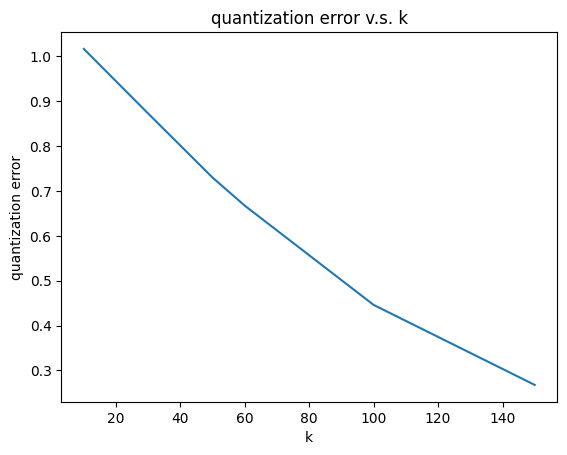

In [107]:
plt.plot(params, errors)
plt.title("quantization error v.s. k")
plt.xlabel("k")
plt.ylabel("quantization error")

Text(0, 0.5, 'compression ratio')

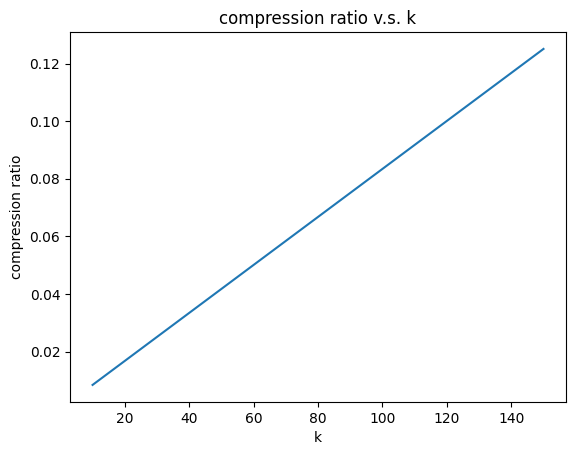

In [108]:
plt.plot(params, ratios)
plt.title("compression ratio v.s. k")
plt.xlabel("k")
plt.ylabel("compression ratio")

## Evaluation

In [147]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [148]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

237it [00:10, 22.75it/s]

[[1900    0    0    0]
 [1894    0    0    0]
 [1895    0    0    4]
 [1784    0    0   91]]


In [149]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 1.0
sports    : 0.0
business  : 0.0
science   : 0.04853333333333333


In [151]:
per_class_acc.mean()

0.26213333333333333

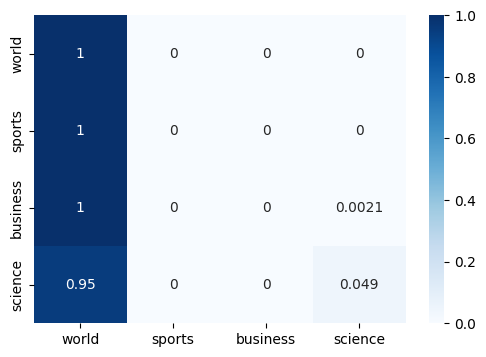

In [152]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

## retraining

In [153]:
model.embeddings.requires_grad_(False)

Embedding(100000, 300)

In [154]:
EPOCHES = 5
ACC_ITERS = 32 / BATCH_SIZE
LR = 1e-3

In [155]:
trainer = ClassificationTrainer(EPOCHES, DEVICE, ACC_ITERS, feature_last=True)

In [156]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [158]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion)

3750it [02:27, 25.40it/s]


epoch 1 : 0.12767885526617367


3750it [02:47, 22.40it/s]


epoch 2 : 0.10248801213900248


3750it [02:49, 22.06it/s]


epoch 3 : 0.09065195331176122


3750it [02:40, 23.39it/s]


epoch 4 : 0.08441672388662895


3750it [02:46, 22.55it/s]

epoch 5 : 0.08062778430978457


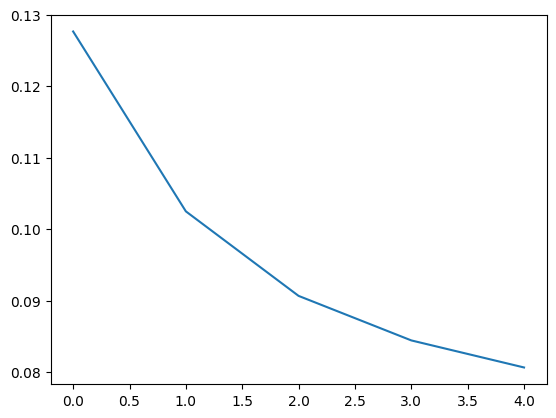

In [159]:
plt.plot(training_loss)

## ReEvaluation

In [160]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [161]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

237it [00:10, 22.05it/s]

[[1723   54   81   42]
 [  18 1856   15    5]
 [  74   19 1674  132]
 [  66   22  186 1601]]


In [162]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.9068421052631579
sports    : 0.9799366420274551
business  : 0.8815165876777251
science   : 0.8538666666666667


In [163]:
per_class_acc.mean()

0.9055405004087512

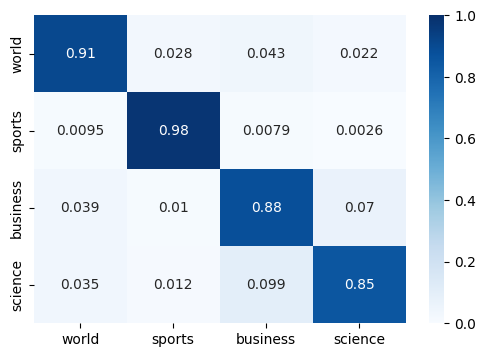

In [164]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

In [166]:
model.embeddings.weight.data

tensor([[ 5.6082e-01,  4.6055e-01, -7.0085e-01,  ..., -1.7091e-04,
         -5.6791e-01,  5.6528e-01],
        [-2.1667e-01, -9.5067e-01,  6.2092e-01,  ...,  1.0502e-01,
          3.1280e-01,  1.1136e+00],
        [-5.3196e-01,  3.9757e-01, -4.4569e-01,  ..., -1.7091e-04,
         -5.6791e-01,  5.6528e-01],
        ...,
        [ 4.5436e-01, -6.4711e-01,  4.6075e-01,  ...,  7.8643e-01,
          7.8176e-01,  2.4869e-02],
        [-2.6512e-01,  2.9283e-01,  2.3335e-01,  ..., -1.5096e+00,
         -1.3425e-02, -3.8063e-01],
        [ 1.6225e+00,  6.0429e-01,  5.8285e-01,  ..., -3.9719e-01,
          5.5825e-01, -4.1728e-02]], device='cuda:0')

## file

In [167]:
model_path = artifact_path / "fasttext.pq.pth"

In [170]:
# embed is popout, save fc only
state = model.state_dict().copy()
state.pop('embed.embeddings.weight')
torch.save(state, model_path)

In [174]:
state.keys()

odict_keys(['embed.special_tokens_embedding.weight', 'fc.weight', 'fc.bias'])

In [172]:
get_file_size(model_path, "K")

'11.11KiB'

In [ ]:
# quantized embed could be retrieved from above quantization files
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>